## Import main functions

In [0]:
from google.colab import drive
drive.mount('/content/gdrive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive/


In [0]:
import sys
sys.path.append('/content/gdrive/My Drive/l4_dataset')

In [0]:
import numpy as np

import keras
from keras.models import load_model
from keras.models import Model
import umap

In [0]:
import matplotlib.pyplot as plt

from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape, PReLU
from keras.models import Model

In [0]:
import os, copy
%matplotlib inline

imw = 192
imh = 192
c = 3
RS = 2211

In [0]:
import seaborn as sns
import matplotlib.patheffects as PathEffects

In [0]:
from sklearn.manifold import TSNE
import umap
import cv2 

Using TensorFlow backend.


## Helper functions

In [0]:
def make_autoencoder():
    input_img = Input(shape=(imw, imh, c))

    x = Conv2D(64, (3, 3), padding='same')(input_img)
    x = PReLU()(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(32, (3, 3), padding='same')(x)
    x = PReLU()(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(32, (3, 3), padding='same')(x)
    x = PReLU()(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(16, (3, 3), padding='same', strides=2)(x)
    x = PReLU()(x)

    encoded = Flatten()(x)

    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), padding='same')(x)
    x = PReLU()(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), padding='same')(x)
    x = PReLU()(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), padding="same")(x)
    x = PReLU()(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(c, (3, 3), activation='sigmoid', padding='same')(x)

    decoder = Model(input_img, decoded)
    encoder = Model(input_img, encoded)
    decoder.compile(optimizer='adam', loss='binary_crossentropy')

    return decoder, encoder

In [0]:
def train(model, data, batch_size=32, epochs=10):
    # get before/after weights (make sure there is a change)
    untrained_weights = np.array(model.get_layer(index=1).get_weights()[0])

    loss = model.fit(data, data, epochs=epochs, batch_size=batch_size)

    trained_weights = np.array(model.get_layer(index=1).get_weights()[0])

    # plot the loss
    plt.figure()
    plt.plot(loss.history['loss'])
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.title("Evolution of loss per epoch")
    plt.grid(True)
    plt.show()

    weight_diff = trained_weights - untrained_weights
    if np.all(weight_diff) == 0:
        print("Training does not seem to have changed the weights. Something might have gone wrong.")
    else:
        print("Model was trained successfully.")

In [0]:
def evaluate(model, data, test):
    plt.rcParams.update({'axes.titlesize': 'medium'})
    train_nb = np.random.randint(0, len(data)-1)
    test_nb = np.random.randint(0, len(test)-1)

    # show the difference in reconstruction
    decoded_imgs = model.predict(data[train_nb:train_nb+1]) # test on images it trained on
    untrained_decoded = model.predict(test[test_nb:test_nb+1]) # test images

    s=10
    fig = plt.figure(figsize=(s,s))
    fig.add_subplot(1, 2, 1)
    show_image(reshape(data[train_nb:train_nb+1], w=imw, h=imh, c=c), "original training image")
    fig.add_subplot(1, 2, 2)
    show_image(reshape(decoded_imgs[0], w=imw, h=imh, c=c), "reconstructed training image")

    fig = plt.figure(figsize=(s,s))
    fig.add_subplot(1, 2, 1)
    show_image(reshape(test[test_nb:test_nb+1], w=imw, h=imh, c=c), "original test image")
    fig.add_subplot(1, 2, 2)
    show_image(reshape(untrained_decoded[0], w=imw, h=imh, c=c), "reconstructed test image")

    plt.show()

In [0]:
def low_clip(x):
    x[x<=255] = 0
    return x

def minmax(x):
    return (x-x.min())/(x.max()-x.min())

def is_faulty(x):
  if x.max() <= 255:
    return True
  return False

In [0]:
def get_label(filename):
    # 0: unstimulated
    # 1: OVA
    # 2: ConA
    # 3: empty/faulty

    # filename format: folder/CKX - L - 00(...)
    file = filename.split("/")[-1].split("(")[0]

    # get letter for DMSO indices
    letter = file.split('-')[1].strip()

    # get number
    number = file[-2:].strip()

    # get plate layout number
    ck = file[:4]

    # DMSO = []

    if ck == "CK19":
        #if number in ["5", "8", "11", "15", "18", "21"] and letter in ["N", "O", "P"]:
        #   DMSO.append(len(labels))
        if number in ["3", "4", "5", "6", "7", "8", "24"]:
            label = 0
        elif number in ["9", "10", "11", "13", "14", "15", "23"]:
            label = 1
        elif number in ["16", "17", "18", "19", "20", "21", "22"]:
            label = 2
        else:
            label = 3
    elif ck == "CK21" or ck == "CK22":
        if number in ["02", "03", "04", "05", "06", "07", "08", "09", "10", "11"]:
            label = 0
        elif int(number) in range(14, 24):
            label = 2
        else:
            label = 3
        #if label != 3 and letter in ["H", "P"]:
        #    DMSO.append(len(labels))
    else:
        print("No CK found")
        return False

    return label
  
def unishuffle(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

In [0]:
def show_image(img, title="untitled", cmap="gray", **kwargs):
    try:
        plt.imshow(img, cmap=cmap, **kwargs)
    except:
        plt.imshow(img[:, :, 0], cmap=cmap, **kwargs)
    plt.axis("off")
    plt.title(title)

def reshape(img, w=imw, h=imh, c=c):
    if c > 1:
      return np.reshape(img, (w, h, c))
    else:
      return np.reshape(img, (w, h))

In [0]:
def convert_to_binary(a):
    val = np.unique(a)[1]
    above_threshold = a >= val 
    under_threshold = a < val
    a[above_threshold] = 1
    a[under_threshold] = 0
    return a.astype(np.uint8).reshape(192,192)

def get_mask(img):
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    _,label,center = cv2.kmeans(img.reshape(np.prod(img.shape), 1),2,None,criteria,10,cv2.KMEANS_RANDOM_CENTERS)
    return convert_to_binary(center[label])

def threshold(x):
    mask = np.copy(x)
    mask = mask.ravel()
    above_threshold = mask > x.mean()+x.std()
    under_threshold = mask <= x.mean() + x.std()
    mask[above_threshold] = 1
    mask[under_threshold] = 0
    return mask.reshape((x.shape))

In [0]:
def plot_range(imgs, rn=8):
  fig = plt.figure(figsize=(15, 15))
  for i in range(1, 6):
    ax = fig.add_subplot(1, 5, i)
    plt.imshow(imgs[i+rn])
    ax.axis('off')

### Comparing performance of cv2 k-means vs. sklearn k means

In [0]:
def cv2_kmeans(img):
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    _,label,center = cv2.kmeans(img.reshape(np.prod(img.shape), 1),2,None,criteria,10,cv2.KMEANS_RANDOM_CENTERS)
    cv_res = center[label]
    cv_img = res.reshape((img.shape))

In [0]:
def sk_kmeans(img):
    kmeans = KMeans(2).fit(img.reshape(np.prod(img.shape), 1))
    sk_res = kmeans.cluster_centers_[kmeans.labels_]
    sk_img = res.reshape((img.shape))

In [0]:
%%time
for i in range(500, 1000):
    cv2_kmeans(minmax(X[i]))

CPU times: user 20.6 s, sys: 11.9 ms, total: 20.6 s
Wall time: 5.19 s


In [0]:
%%time
for i in range(500, 1000):
    sk_kmeans(minmax(X[i]))

CPU times: user 1min 3s, sys: 504 ms, total: 1min 3s
Wall time: 1min 3s


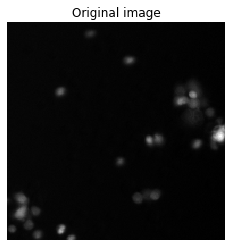

In [0]:
show_image(img, "Original image")

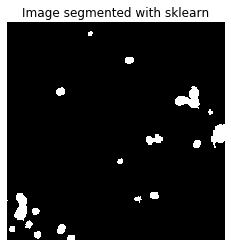

In [0]:
show_image(sk_img, "Image segmented with sklearn")

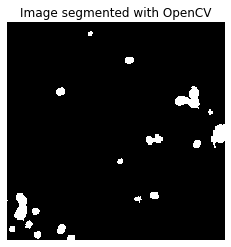

In [0]:
show_image(cv_img, "Image segmented with OpenCV")

In [0]:
False in (sk_img == cv_img)

False

### Comparing performance of thresholding vs. k-means

In [0]:
def threshold(x):
    mask = np.copy(x)
    mask = mask.ravel()
    above_threshold = mask > x.mean()+x.std()
    under_threshold = mask <= x.mean() + x.std()
    mask[above_threshold] = 1
    mask[under_threshold] = 0
    return mask.reshape((x.shape))

In [0]:
%%time
for i in range(500, 1000):
    threshold(minmax(X[i]))

CPU times: user 180 ms, sys: 2 µs, total: 180 ms
Wall time: 181 ms


In [0]:
%%time
for i in range(500, 1000):
    get_mask(minmax(X[i]))

CPU times: user 21 s, sys: 37.7 ms, total: 21 s
Wall time: 5.49 s


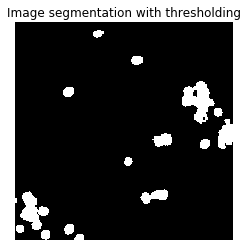

In [0]:
show_image(threshold(img), "Image segmentation with thresholding")

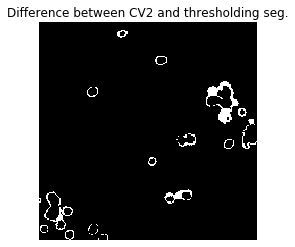

In [0]:
show_image(threshold(img)-get_mask(img), "Difference between CV2 and thresholding seg.")

## Helper functions for evaluating model

In [0]:
def plot_clusters(X, y, labels=["Unstimulated", "OVA", "ConA", "Faulty"]):
    targets = range(len(labels))
    palette = np.array(sns.color_palette("hls", len(labels)))

    y = np.array(y)

    fig = plt.figure()
    ax = plt.subplot()

    for target, color, label in zip(targets, palette, labels):
        plt.scatter(X[y==target, 0], X[y==target, 1], c=[color], label=label, alpha=0.75, s=10)

    ax.axis('off')
    ax.grid(False)

    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    plt.show()

## Read images

In [0]:
npzfile = np.load('/content/gdrive/My Drive/l4_dataset/dmso_unmodified.npz')

In [0]:
y = npzfile['y']

In [0]:
y_dmso = np.array([get_label(i) for i in y])

In [0]:
X = npzfile['x']

## Process images into dataset

In [0]:
def preprocess(data, labels, mask=False):
  # avoid changing the dataset directly
  data = np.copy(data)

  # initialise arrays for filling in
  x_data = np.ndarray(shape=(len(data)//2, 192, 192, 3))
  y_data = np.ndarray(shape=(len(data)//2))

  # initialise index values
  idx = 0
  i = 0

  # loop through images and process 
  while idx < (len(data)):
    # ignore 100, 300, etc. values as they will already have been processed 
    if (idx % 100 == 0) and (idx % 200 != 0):
      idx += 100
    else:
        # if the image is "faulty" we cannot low_clip and apply minmax -> NaN
        if is_faulty(data[idx]) or is_faulty(data[idx+100]):
            tcell = minmax(data[idx])
            dcell = minmax(data[idx+100])
            y_data[i] = 3
        else:
            tcell = minmax(low_clip(data[idx]))
            dcell = minmax(low_clip(data[idx+100]))
            y_data[i] = labels[idx]
        
        # mask out the background
        if mask:
          x_data[i, ..., 0] = dcell*get_mask(dcell) # red-coloured
          x_data[i, ..., 1] = tcell*get_mask(tcell) # green-coloured
        else:
          x_data[i, :, :, 0] = dcell
          x_data[i, :, :, 1] = tcell
        idx+=1
        i+=1

        # try and save memory 
        tcell = None
        dcell = None
  
  print('Images preprocessed. Size of dataset: {}'.format(len(x_data)))
  return x_data, y_data

In [0]:
x_combined, y_combined = preprocess(X, y_dmso)

Images preprocessed. Size of dataset: 9800


In [0]:
X, y_dmso = None, None

In [0]:
x_masked, y_masked = preprocess(X, y_dmso, mask=True)       

Images preprocessed. Size of dataset: 9800


In [0]:
x_masked, y_masked = None, None

In [0]:
x_train, y_train = unishuffle(x_combined, y_combined)

## Autoencoder model

In [0]:
decoder, encoder = make_autoencoder()

In [0]:
train(decoder, x_train)

In [0]:
decoder.save("/content/gdrive/My Drive/l4_dataset/decoder_weights.h5")

In [0]:
encoder.save("/content/gdrive/My Drive/l4_dataset/encoder_weights.h5")

## High dimensional visualisation to GIF

In [0]:
# monkey patch gradient descent 
import sklearn

positions = []

def _gradient_descent(objective, p0, it, n_iter,
                      n_iter_check=1, n_iter_without_progress=300,
                      momentum=0.8, learning_rate=200.0, min_gain=0.01,
                      min_grad_norm=1e-7, verbose=0, args=None, kwargs=None):

    if args is None:
        args = []
    if kwargs is None:
        kwargs = {}

    p = p0.copy().ravel()
    update = np.zeros_like(p)
    gains = np.ones_like(p)
    error = np.finfo(np.float).max
    best_error = np.finfo(np.float).max
    best_iter = i = it

    for i in range(it, n_iter):
        positions.append(p.copy())
        
        check_convergence = (i + 1) % n_iter_check == 0
        # only compute the error when needed
        kwargs['compute_error'] = check_convergence or i == n_iter - 1

        error, grad = objective(p, *args, **kwargs)
        grad_norm = linalg.norm(grad)

        inc = update * grad < 0.0
        dec = np.invert(inc)
        gains[inc] += 0.2
        gains[dec] *= 0.8
        np.clip(gains, min_gain, np.inf, out=gains)
        grad *= gains
        update = momentum * update - learning_rate * grad
        p += update

        if check_convergence:

            if verbose >= 2:
                print("[t-SNE] Iteration %d: error = %.7f,"
                      " gradient norm = %.7f"
                      " (%s iterations in %0.3fs)"
                      % (i + 1, error, grad_norm, n_iter_check, duration))

            if error < best_error:
                best_error = error
                best_iter = i
            elif i - best_iter > n_iter_without_progress:
                if verbose >= 2:
                    print("[t-SNE] Iteration %d: did not make any progress "
                          "during the last %d episodes. Finished."
                          % (i + 1, n_iter_without_progress))
                break
            if grad_norm <= min_grad_norm:
                if verbose >= 2:
                    print("[t-SNE] Iteration %d: gradient norm %f. Finished."
                          % (i + 1, grad_norm))
                break

    return p, error, i

sklearn.manifold.t_sne._gradient_descent = _gradient_descent

In [0]:
def scatter_gif(x, colors, labels=["Unstimulated", "OVA", "ConA"]):
    palette = np.array(sns.color_palette("hls", len(labels)))
    colors = np.array(colors)
    
    f = plt.figure(figsize=(8,8))
    ax = plt.subplot()
    
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40,
                    c=palette[colors.astype(np.int)])
    
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')

    return f, sc

In [0]:
from scipy import linalg

from moviepy.video.io.bindings import mplfig_to_npimage
import moviepy.editor as mpy

In [0]:
def make_gif(out, x, y, labels=["Unstimulated", "OVA", "ConA"]):
    def make_frame_mpl(t):
        i = int(t*40)
        x = X_iter[..., i]
        sc.set_offsets(x)
        return mplfig_to_npimage(f)

    X_proj = TSNE(random_state=RS).fit_transform(x)
    X_iter = np.dstack(position.reshape(-1, 2) for position in positions)
    
    f, sc = scatter_gif(X_iter[..., -1], y, labels=labels)
    
    animation = mpy.VideoClip(make_frame_mpl,
                          duration=X_iter.shape[2]/40.)
    animation.write_gif(out, fps=20)

In [0]:
make_gif('/content/gdrive/My Drive/l4_dataset/cluster_combined_1.gif', encoded, y_combined)
